,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1



Shape: (101, 18)


/tmp/ipython-input-3-4168266216.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="type", data=df, palette="viridis")


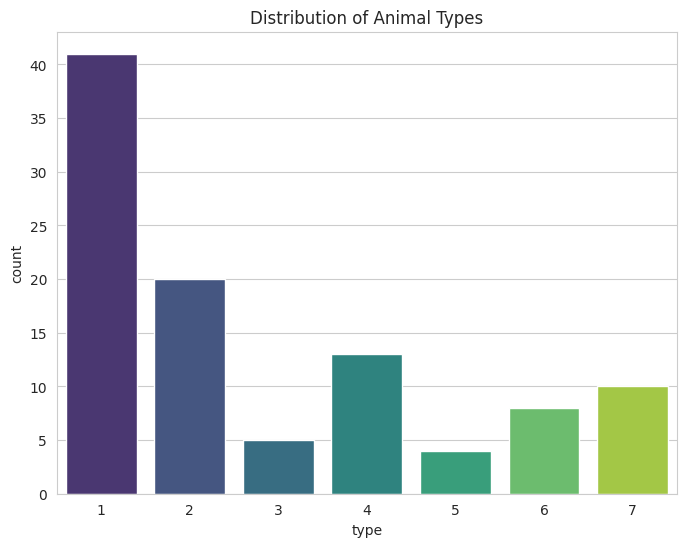

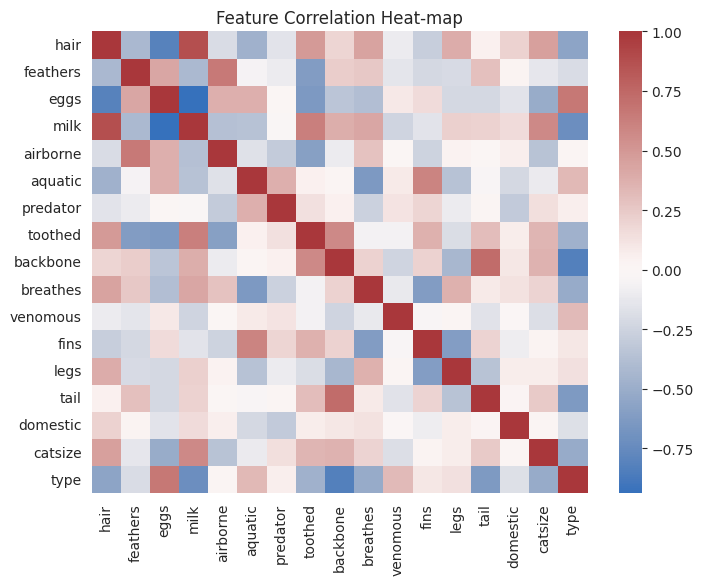

Missing values per column:
 animal name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
type           0
dtype: int64


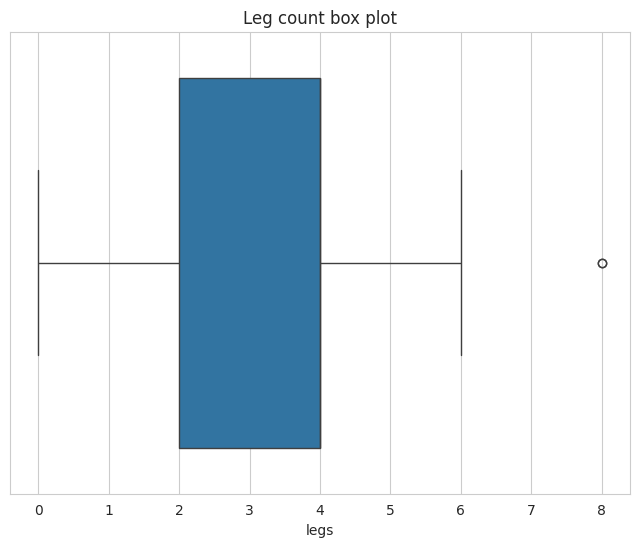

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'metric': 'manhattan', 'n_neighbors': np.int64(1)}
CV accuracy : 0.95

Test set metrics
-----------------
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1‑score : 1.0

Detailed report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



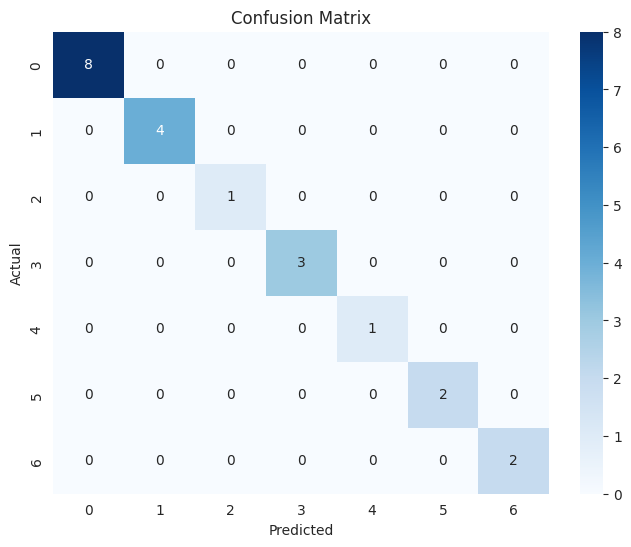

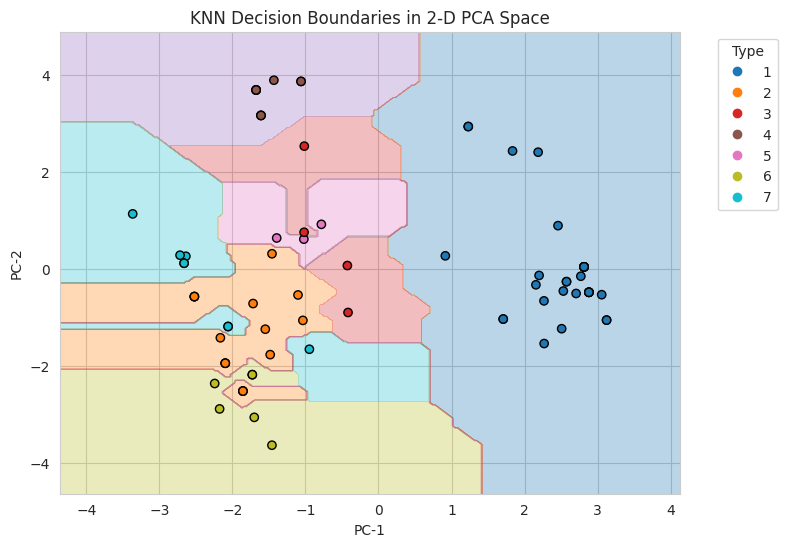

In [ ]:


# ---------- 1. Imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# ---------- 2. Load & inspect data ----------
df = pd.read_csv("/content/Zoo.csv")      # adjust path if needed
display(df.head())
print("\nShape:", df.shape)

# ---------- 3. Exploratory Data Analysis ----------
sns.countplot(x="type", data=df, palette="viridis")
plt.title("Distribution of Animal Types")
plt.show()

corr = df.drop(columns=["animal name"]).corr()
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Feature Correlation Heat‑map")
plt.show()

# ---------- 4. Data preprocessing ----------
print("Missing values per column:\n", df.isna().sum())

sns.boxplot(x=df["legs"])
plt.title("Leg count box plot")
plt.show()

X = df.drop(columns=["animal name", "type"])
y = df["type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ---------- 5. Hyper‑parameter tuning ----------
param_grid = {
    "n_neighbors": np.arange(1, 21),
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("CV accuracy :", round(grid.best_score_, 4))

knn = grid.best_estimator_

# ---------- 6. Evaluation on test set ----------
y_pred = knn.predict(X_test_scaled)

print("\nTest set metrics")
print("-----------------")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred, average="weighted"), 4))
print("Recall   :", round(recall_score(y_test, y_pred, average="weighted"), 4))
print("F1‑score :", round(f1_score(y_test, y_pred, average="weighted"), 4))
print("\nDetailed report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- 7. Decision‑boundary visualisation ----------
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

knn_2d = KNeighborsClassifier(
    n_neighbors=knn.n_neighbors, metric=knn.metric
).fit(X_train_pca, y_train)

x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")

# ----‑‑‑‑‑ fixed legend code ‑‑‑‑‑----
scatter = plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=y_train, edgecolor="k", cmap="tab10"
)
handles, labels = scatter.legend_elements()      # ← no 'title' kw‑arg here
plt.legend(
    handles, labels, title="Type",               # ← title goes in plt.legend
    bbox_to_anchor=(1.05, 1), loc="upper left"
)
# ------------------------------------

plt.xlabel("PC‑1")
plt.ylabel("PC‑2")
plt.title("KNN Decision Boundaries in 2‑D PCA Space")
plt.show()


INTERVEIW QUESTIONS
1. What are the key hyperparameters in KNN?
The key hyperparameters in KNN are:

Hyperparameter	Description
n_neighbors (K)	Number of nearest neighbors to consider for voting. A small K can be sensitive to noise, while a large K can smooth over distinctions.
metric	Distance function used to compute the similarity between points. Common options include Euclidean, Manhattan, Minkowski, etc.
weights	Weighting scheme for neighbors:
 • 'uniform': all neighbors have equal weight
 • 'distance': closer neighbors get more weight
algorithm	Search algorithm used to find nearest neighbors:
 • 'auto', 'ball_tree', 'kd_tree', 'brute'
 (affects speed, not accuracy)
leaf_size	Affects speed of tree-based algorithms (Ball Tree / KD Tree), not predictive accuracy. Relevant when algorithm is set accordingly.
p (for Minkowski)	Power parameter:
 • p=1 is Manhattan distance
 • p=2 is Euclidean distance
 • Other values generalize the metric

2. What distance metrics can be used in KNN?
KNN supports a variety of distance metrics, including:

Metric	Description
Euclidean (p=2)	Straight-line (L2 norm): $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + \dots}$
Manhattan (p=1)	City block (L1 norm): $
Minkowski	Generalized form: $p$ is adjustable
Chebyshev	Maximum coordinate difference: $\max_i
Cosine similarity	Measures angle between vectors (used more in text/NLP applications)
Hamming	Used for categorical or binary attributes (e.g. strings or boolean features)